
## Implementing a custom activation function



In [ ]:
import tensorflow as tf
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.activations import elu
from tensorflow.math import exp
from tensorflow.math import multiply
from tensorflow.math import divide
from tensorflow.math import square
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import pandas as pd

### Exercise 1: implement the PELU


In [ ]:
class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape):
        
        paramater_init = tf.random_uniform_initializer(minval=0.1, maxval=0.9)
        self.paramater_A = self.add_weight(shape=(self.units,), initializer=paramater_init, trainable=True,constraint = NonNeg(),
dtype='float32')
        self.paramater_B = self.add_weight(shape=(self.units,), initializer=paramater_init, trainable=True,constraint = NonNeg(),
dtype='float32')
        
    def call(self, inputs): # Defines the computation from inputs to outputs
        alpha_=self.paramater_A
        beta=self.paramater_B
        input_tensor= divide(inputs,beta)
        output_tensor = elu(input_tensor, alpha=1.0)
        return  multiply(alpha_, output_tensor)       

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [ ]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.

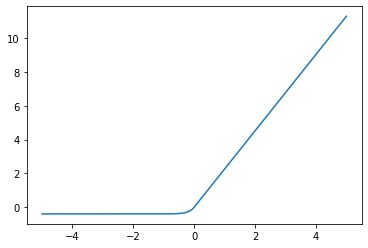

In [ ]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5.0, 5.0, 200) # An equispaced grid of 200 points in [-5, +5]
y_range = pelu(x_range)

plt.plot(x_range.numpy(), y_range.numpy())

**Exercise 2.2**: using a tf.GradientTape object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

In [ ]:
#Derivative function of PELU w.r.t alpha
def der_pelu_a(inputs):
  alpha_=pelu.paramater_A
  beta=pelu.paramater_B
  
  return  divide(inputs * tf.cast(inputs>=0, dtype='float32') , beta) + exp(divide(inputs * tf.cast(inputs<0, dtype='float32') , beta) ) -1

In [ ]:
der_peluA=der_pelu_a(x_range)

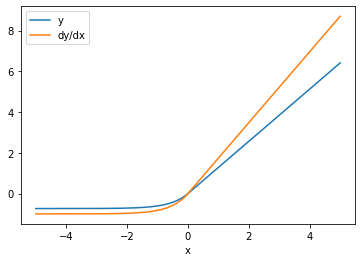

In [ ]:
# using a tf.GradientTape object & Jacobian, compute the derivative(w.r.t a)  
delta= pelu.paramater_A
with tf.GradientTape() as tape:

  y = pelu(x_range)

dy_dx = tape.jacobian(y, delta)
dy_dx  = tf.reshape(dy_dx, shape = (-1,))
#When you take the Jacobian with respect to a scalar the result has the shape of the target, and gives the gradient of the each element with respect to the source:
plt.plot(x_range.numpy(), y_range, label='y')
plt.plot(x_range.numpy(), dy_dx, label='dy/dx')
plt.legend()
_= plt.xlabel('x')

In [ ]:
tf.reduce_all(tf.abs(der_peluA - dy_dx) < 1e-4) #check its correctness up to a certain numerical precision.

<tf.Tensor: shape=(), dtype=bool, numpy=True>

try the same for the  β  parameter

In [ ]:
#Derivative function of PELU w.r.t beta
def der_pelu_b(inputs):
  
  alpha_=pelu.paramater_A
  beta=pelu.paramater_B
  #if x>=0 --> -alpha*x / exp(square(beta))
  # if x<0 --> - alpha * x * exp(x/beta) / square(beta)
  return  -1* divide(multiply(inputs * tf.cast(inputs>=0, dtype='float32'),alpha_) ,square(beta)) +  -1*multiply(multiply(divide(inputs * tf.cast(inputs<0, dtype='float32') , square(beta)),alpha_),exp(divide(inputs,beta)) )


In [ ]:
der_peluB=der_pelu_b(x_range)


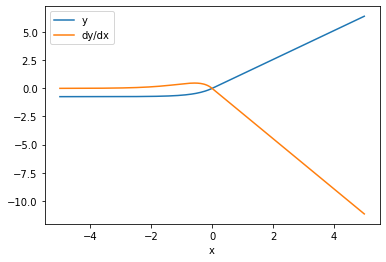

In [ ]:
# using a tf.GradientTape object & Jacobian, compute the derivative(w.r.t b)
deltaB= pelu.paramater_B
with tf.GradientTape() as tape:

  y = pelu(x_range)

dy_dx_B = tape.jacobian(y, deltaB)
dy_dx_B  = tf.reshape(dy_dx_B, shape = (-1,))
#When you take the Jacobian with respect to a scalar the result has the shape of the target, and gives the gradient of the each element with respect to the source:
plt.plot(x_range.numpy(), y_range, label='y')
plt.plot(x_range.numpy(), dy_dx_B, label='dy/dx')
plt.legend()
_= plt.xlabel('x')

In [ ]:
tf.reduce_all(tf.abs(der_peluB - dy_dx_B) < 1e-4) #check its correctness up to a certain numerical precision.

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In [ ]:
from sklearn import datasets, model_selection, preprocessing

In [ ]:
 mnist_test= pd.read_csv("/content/sample_data/mnist_test.csv", header=None)

In [ ]:
mnist_train_small = pd.read_csv("/content/sample_data/mnist_train_small.csv", header=None)

In [ ]:
X_tr =  mnist_train_small.iloc[:, 1:].values.astype('float32')
y_tr =  mnist_train_small.iloc[:, 0].values.reshape(-1,1).astype('float32')

X_tst = mnist_test.iloc[:, 1:].values.astype('float32')
y_tst = mnist_test.iloc[:, 0].values.reshape(-1,1).astype('float32')

In [ ]:
# Standard scaling in scikit-learn
scaler = preprocessing.StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_tst = scaler.transform(X_tst)

train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_tst, y_tst)).batch(32)

In [ ]:
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
acc = metrics.SparseCategoricalAccuracy()
cross_entropy = losses.SparseCategoricalCrossentropy()
sgd = optimizers.SGD(learning_rate=1e-3)
# Compile writes all the previous training code for us!

model.compile(optimizer=sgd,
              loss=cross_entropy,
              metrics=[acc])

model.fit(train_dataset, epochs=25,  validation_data=test_dataset)

Epoch 1/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9562 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.9287
Epoch 2/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.9284
Epoch 3/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.9287
Epoch 4/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.3082 - val_sparse_categorical_accuracy: 0.9291
Epoch 5/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9295
Epoch 6/25
625/625 [==============================] - 1s 2ms/step - loss: 0.1437 - sparse_categorica